<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные, изучить почасовые колебания в течение суток, тренд и сезонность временного ряда.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке, убедиться в том, что достигнуто необходимое значение метрики RMSE. 
5. Cделать общие выводы по работе.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# обновляем библиотеки
!pip install -q scikit-learn==1.6.0
!pip install catboost -q

In [2]:
# загружаем все необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import os

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler, TargetEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline

from catboost import CatBoostRegressor

In [3]:
# установим опцию отображения максимальной ширины столбцов
pd.set_option('display.max_colwidth', None)

In [4]:
# фиксируем константы
RANDOM_STATE = 123
TEST_SIZE = 0.1

In [5]:
# загружаем данные в датафрейм
path1 = 'https://code.s3.yandex.net/datasets/taxi.csv'
path2 = 'C:/Users/user/Documents/practicum_datasets/taxi.csv'

if os.path.exists(path1):
    taxi = pd.read_csv(path1, index_col=[0], parse_dates=[0])
elif os.path.exists(path2):
    taxi = pd.read_csv(path2, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')

In [6]:
# смотрим общую информацию по датафрейму
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
# выводим первые строки датафрейма
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [8]:
# ресемплируем временой ряд по одному часу и отсортируем по индексу
taxi = taxi.resample('1h').sum()
taxi = taxi.sort_index()

In [9]:
# выведем первые строки временного ряда
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

In [11]:
# выведем минимальные и максимальные значения по индексу
print(taxi.index.min())
print(taxi.index.max())

2018-03-01 00:00:00
2018-08-31 23:00:00


In [12]:
# выведем описательную статистику для целевого признака
taxi.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [13]:
# убедимся, что у нас нет пустых значений
taxi.isna().sum()

num_orders    0
dtype: int64

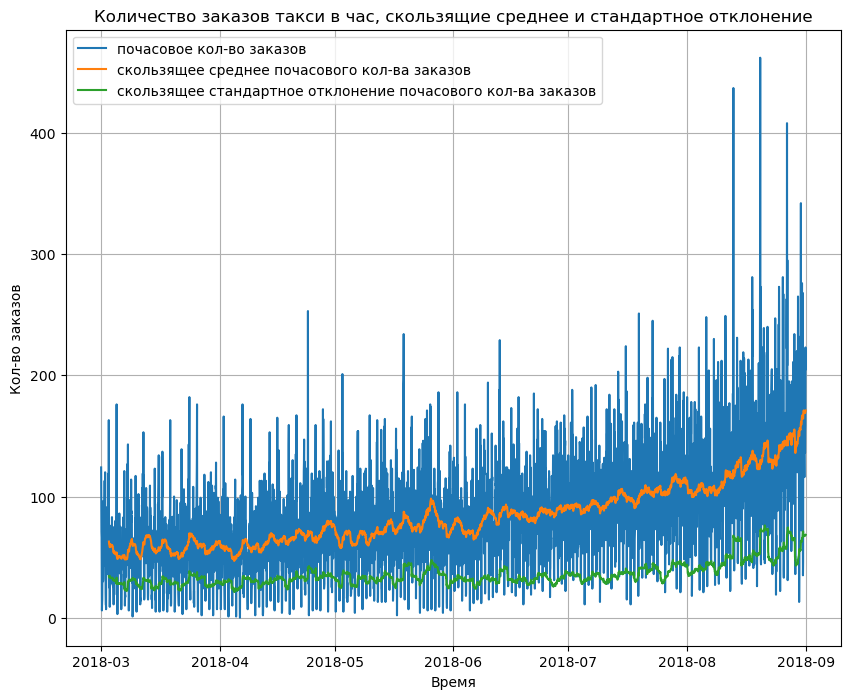

In [14]:
# построим графики почасового кол-ва заказов, скользящих среднего и стандартного отклонения
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(taxi)
ax.plot(taxi.rolling(50).mean())
ax.plot(taxi.rolling(50).std())
plt.grid(True)
plt.title('Количество заказов такси в час, скользящие среднее и стандартное отклонение')
plt.ylabel('Кол-во заказов')
plt.xlabel('Время')
plt.legend(['почасовое кол-во заказов', 'скользящее среднее почасового кол-ва заказов',
            'скользящее стандартное отклонение почасового кол-ва заказов'])
plt.show()

По графику кол-ва заказов сложно увидеть почасовое кол-во заказов, но можно сделать выводы в целом о тренде временного ряда. Предположительно мы имеем дело с нестационарным временным рядом, т.к. среднее и стандартное отклонение похоже изменяются со временем, что показывают летние месяцы. Однако, чтобы точно подтвердить наше предположение, следует провести статистический тест Дики-Фуллера. Чтобы посмотреть почасовую тенденцию в течение суток нам нужно рассмотреть график на более коротком промежутке.   

In [16]:
ad_result = adfuller(taxi)

print('Augmented Dickey-Fuller Statistic:', ad_result[0]) 
print('p-value:', ad_result[1])

Augmented Dickey-Fuller Statistic: -3.0689242890279513
p-value: 0.02894005140261326


In [17]:
if ad_result[1] <= 0.05:
    print("Нулевая гипотеза отвергается, ряд является стационарным")
else:
    print("Нулевая гипотеза принимается, ряд не является стационарным")

Нулевая гипотеза отвергается, ряд является стационарным


Выдвинутая гипотеза о нестационарности нашего врменного ряда не нашла тестового подтверждения, что означает, что наш временной ряд стационарный.

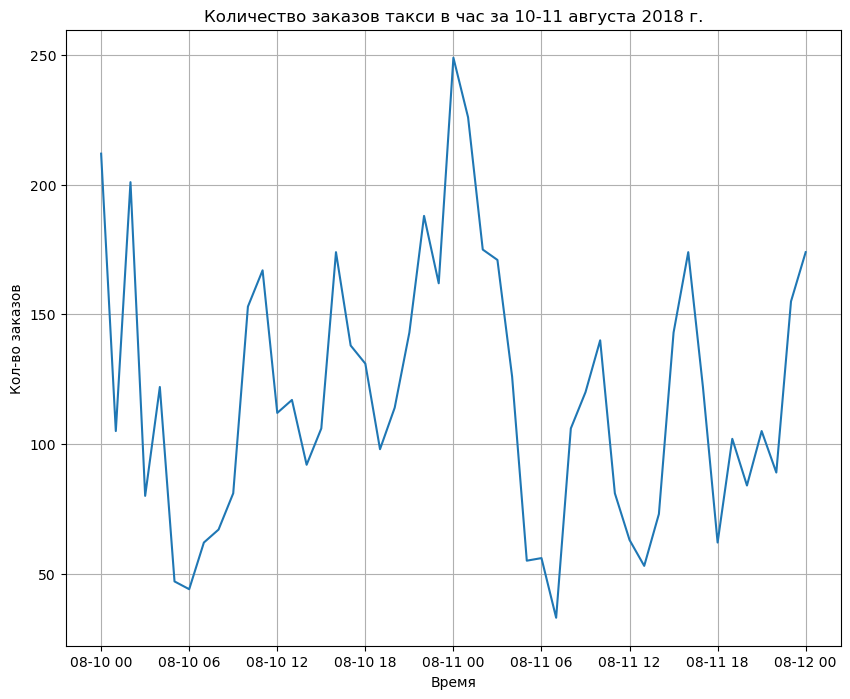

In [19]:
# посмотрим график посуточных заказов за двое суток
plt.figure(figsize=(10, 8))
plt.plot(taxi['2018-08-10':'2018-08-12 00:00:00'])
plt.grid(True)
plt.title('Количество заказов такси в час за 10-11 августа 2018 г.')
plt.ylabel('Кол-во заказов')
plt.xlabel('Время')
plt.show()

На графике четко прослеживаются колебания кол-ва заказов в час в течение суток. Пиковое значение кол-ва заказов приходитя на ночное время 00 часов. После пикового часа происходит резкое падение кол-ва заказов и к 6-7 часам кол-во заказов достигает минимального за сутки, после чего снова начинается рост кол-ва заказов до 10-11 часов. Затем начинается незначительный спад до 13-14 часов, потом происходит дневной рост и снова спад в течение 16-18 часов, а затем снова рост вплоть до пикового значения. 

In [21]:
# разложим временой ряд на тренд, сезонность и остаточную составляющие
decomposed = seasonal_decompose(taxi)

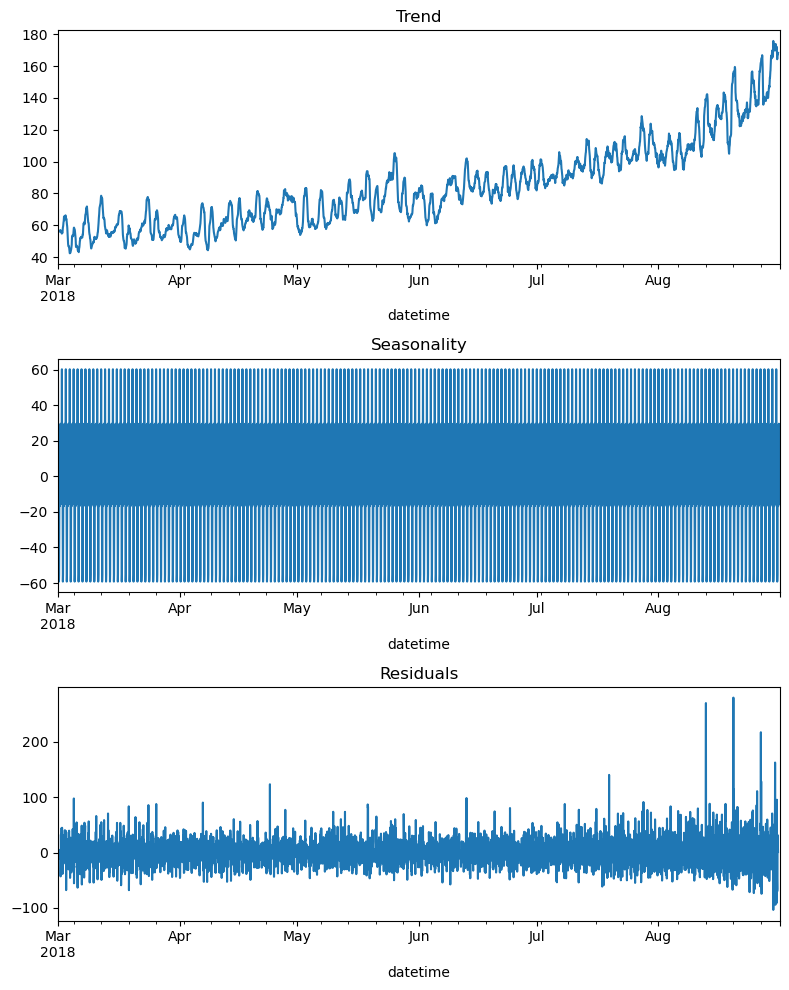

In [22]:
# построим графики тренда, сезонной и остаточной составляющих
plt.figure(figsize=(8, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Виден очевидный тренд к росту со второй декады апреля по конец мая, потом непродолжительный спад с конца мая по начало июня и потом продолжающийся рост до конца августа. Особенно явно тенденция к росту проявлянется в августе. Сезонные колебания проявляются в течение очень короткого периода, чтобы лучше их рассмотреть построим график за более короткий период - за август.

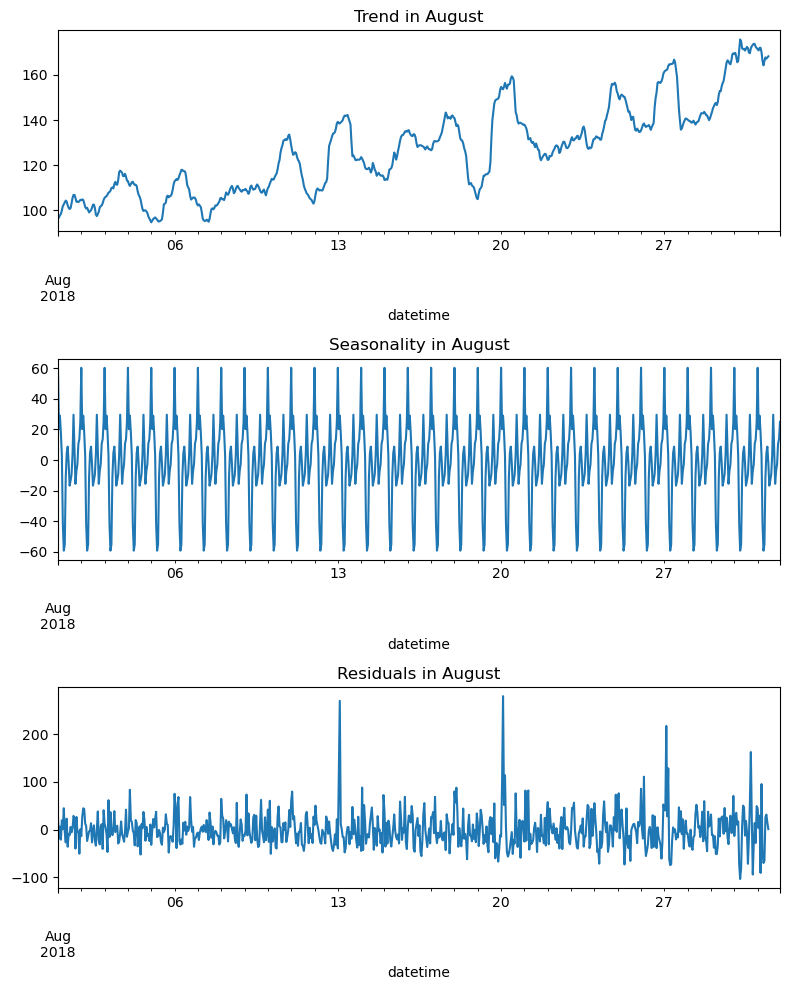

In [24]:
# посмотрим тренд, сезонность и остаточную составляющую за август
plt.figure(figsize=(8, 10))
plt.subplot(311)
decomposed.trend['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('Trend in August')
plt.subplot(312)
decomposed.seasonal['2018-08-01':'2018-08-31'].plot(ax=plt.gca())# < напишите код здесь >
plt.title('Seasonality in August')
plt.subplot(313)
decomposed.resid['2018-08-01':'2018-08-31'].plot(ax=plt.gca()) # < напишите код здесь >
plt.title('Residuals in August')
plt.tight_layout()

На примере конкретного месяца августа мы наблюдаем плавный тренд к росту в течение месяца, а также видим, что сезонность проявляется в течение суток, когда график достигает минимума и максимума, а затем повторяет себя в последующие сутки. Мы видим также видим 4 заметных всплеска значений остатков.

In [26]:
# создадим новые признаки в датафрейме и выведем первые строки
taxi['day'] = taxi.index.day
taxi['day_of_week'] = taxi.index.dayofweek
taxi['hour'] = taxi.index.hour
taxi['lag_1'] = taxi['num_orders'].shift(1)
taxi['lag_2'] = taxi['num_orders'].shift(2)
taxi['lag_3'] = taxi['num_orders'].shift(3)
taxi['rolling_mean_10'] = taxi['num_orders'].shift().rolling(10).mean()
taxi['rolling_mean_15'] = taxi['num_orders'].shift().rolling(15).mean()
display(taxi.head(10))

,num_orders,day,day_of_week,hour,lag_1,lag_2,lag_3,rolling_mean_10,rolling_mean_15
datetime,,,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,1,3,4,66.0,71.0,85.0,NaN,NaN
2018-03-01 05:00:00,6,1,3,5,43.0,66.0,71.0,NaN,NaN
2018-03-01 06:00:00,12,1,3,6,6.0,43.0,66.0,NaN,NaN
2018-03-01 07:00:00,15,1,3,7,12.0,6.0,43.0,NaN,NaN
2018-03-01 08:00:00,34,1,3,8,15.0,12.0,6.0,NaN,NaN


**Вывод:** 

На этапе анализа мы проанализировали целевой признак - почасовое кол-во заказов, а затем добавили необходимые входные признаки для прогнозирования целевого признака. Мы видим, что почасовое кол-во заказов в целом за выбранный период имеет заметный тренд к росту, который наблюдается с начала апреля по конец августа. В конце мая - начале июня происходит незначительный спад. А в течение августа наблюдается наиболее резкий рост кол-ва заказов в час и наиболее резкие колебания кол-ва почасовых заказов (стандратное отклонение заметно увеличивается). При этом очень сильные колебания происходят в течение суток, сезонная составляющая указывает именно на цикличность в течение суток. По выборке максимальное значение кол-ва заказов в час составляет 462, а минимальное 0. Медианное значение кол-ва заказов за час - 78.

Хотя судя по графику мы склонны думать, что среднее и стандартное отклонение изменяются со временем, наше предположение не подтвердилось тестом. Тест на стационарность не подтвердил нулевую гипотезу о нестационарности временного ряд, т.е. наш временной ряд стационарный.

График на более коротком промежутке за двое суток показывает, что обычно пиковые значения приходятся на 00 часов ночи, а минимуальные значения на 6 часов утра.

В качестве входных признаков для прогнозирования кол-ва почасовых заказов мы добавили месяц, день, день недели и час в течение суток, лаги на 1, 2, 3 часа, скользящие средние на 10 и 15 часов.

## Обучение

In [29]:
# разбиваем выборку на тренировочную и тестовую
train, test = train_test_split(taxi, shuffle=False, test_size=TEST_SIZE)

# выводим по индексу минимальное и масимальное значение
# выодим размерность тестовой выборки
print(test.index.min())
print(test.index.max())
print(test.shape)

2018-08-13 14:00:00
2018-08-31 23:00:00
(442, 9)


In [30]:
train = train.dropna()
print(train.index.min())
print(train.index.max())
print(train.shape)

2018-03-01 15:00:00
2018-08-13 13:00:00
(3959, 9)


In [31]:
# определяем входные и целевой признаки для тренировочной и тестовой выборок
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [32]:
targ_columns = ['day_of_week', 'hour']
num_columns = ['day', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_10', 'rolling_mean_15']

# создаем пайплайн для обработки данных
data_preprocessor = ColumnTransformer(
    [
        ('targ', TargetEncoder(target_type='continuous', smooth=9,
                               random_state=RANDOM_STATE), targ_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [33]:
# задаём прогнозную модель через пайплайн и задаём параметры для модели
model = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

# для модели LinearRegressor()
parameters_lr = [
    {
        'models': [LinearRegression(n_jobs=-1)]
    }
                    ]
    # для модели Lasso()
parameters_lasso = [
    {
        'models': [Lasso(random_state=RANDOM_STATE)],
        'models__alpha': [0.01, 0.1, 0.3, 0.5]
    }
                    ]

    # для модели Ridge()
parameters_ridge = [
    {
        'models': [Ridge(random_state=RANDOM_STATE)],
        'models__alpha': [3, 5, 7, 10]
    }
                   ]

    # для модели KNeighborsRegressor()
parameters_knn = [
    {
        'models': [KNeighborsRegressor(n_jobs=-1)],
        'models__n_neighbors': [3, 5, 7, 10],
        'models__p': [1]
    }
                 ]
    
    # для модели RandomForestRegressor()
parameters_rfr = [
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE,
                                        bootstrap=True)],
        'models__max_depth': [7, 10, 15, 20],
        'models__min_samples_leaf': [3, 5, 7]
    }
                  ]

In [34]:
# применим инструмент для кросс-валидации временных рядов
time_split = TimeSeriesSplit(n_splits=5)

# инициализируем класс для автоматизированного поиска лучших гиперпараметров\
# на данных кросс-валидационной выборки 
# запускаем поиск гиперпараметров c помощью GridSearchCV
best_lr_model = GridSearchCV(model, param_grid=parameters_lr, cv=time_split,
                             scoring='neg_root_mean_squared_error',
                             n_jobs=-1)

best_lr_model.fit(X_train, y_train)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('targ',
                                                                         TargetEncoder(random_state=123,
                                                                                       smooth=9,
                                                                                       target_type='continuous'),
                                                                         ['day_of_week',
                                                                          'hour']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['day',
                                                                          'lag_1',
                                                                          'lag_2',
                                                                          'lag_3',
                                                                          'rolling_mean_10',
                                                                          'rolling_mean_15'])])),
                                       ('models', LinearRegression())]),
             n_jobs=-1, param_grid=[{'models': [LinearRegression(n_jobs=-1)]}],
             scoring='neg_root_mean_squared_error')

In [35]:
# инициализируем класс для автоматизированного поиска лучших гиперпараметров\
# на данных кросс-валидационной выборки 
# запускаем поиск гиперпараметров c помощью GridSearchCV
best_lasso_model = GridSearchCV(model, param_grid=parameters_lasso, cv=time_split,
                             scoring='neg_root_mean_squared_error',
                             n_jobs=-1)

best_lasso_model.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('targ',
                                                                         TargetEncoder(random_state=123,
                                                                                       smooth=9,
                                                                                       target_type='continuous'),
                                                                         ['day_of_week',
                                                                          'hour']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['day',
                                                                          'lag_1',
                                                                          'lag_2',
                                                                          'lag_3',
                                                                          'rolling_mean_10',
                                                                          'rolling_mean_15'])])),
                                       ('models', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'models': [Lasso(random_state=123)],
                          'models__alpha': [0.01, 0.1, 0.3, 0.5]}],
             scoring='neg_root_mean_squared_error')

In [36]:
# инициализируем класс для автоматизированного поиска лучших гиперпараметров\
# на данных кросс-валидационной выборки 
# запускаем поиск гиперпараметров c помощью GridSearchCV
best_ridge_model = GridSearchCV(model, param_grid=parameters_ridge, cv=time_split,
                             scoring='neg_root_mean_squared_error',
                             n_jobs=-1)

best_ridge_model.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('targ',
                                                                         TargetEncoder(random_state=123,
                                                                                       smooth=9,
                                                                                       target_type='continuous'),
                                                                         ['day_of_week',
                                                                          'hour']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['day',
                                                                          'lag_1',
                                                                          'lag_2',
                                                                          'lag_3',
                                                                          'rolling_mean_10',
                                                                          'rolling_mean_15'])])),
                                       ('models', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'models': [Ridge(random_state=123)],
                          'models__alpha': [3, 5, 7, 10]}],
             scoring='neg_root_mean_squared_error')

In [37]:
# инициализируем класс для автоматизированного поиска лучших гиперпараметров\
# на данных кросс-валидационной выборки 
# запускаем поиск гиперпараметров c помощью GridSearchCV
best_knn_model = GridSearchCV(model, param_grid=parameters_knn, cv=time_split,
                             scoring='neg_root_mean_squared_error',
                             n_jobs=-1)

best_knn_model.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('targ',
                                                                         TargetEncoder(random_state=123,
                                                                                       smooth=9,
                                                                                       target_type='continuous'),
                                                                         ['day_of_week',
                                                                          'hour']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['day',
                                                                          'lag_1',
                                                                          'lag_2',
                                                                          'lag_3',
                                                                          'rolling_mean_10',
                                                                          'rolling_mean_15'])])),
                                       ('models', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'models': [KNeighborsRegressor(n_jobs=-1)],
                          'models__n_neighbors': [3, 5, 7, 10],
                          'models__p': [1]}],
             scoring='neg_root_mean_squared_error')

In [38]:
# инициализируем класс для автоматизированного поиска лучших гиперпараметров\
# на данных кросс-валидационной выборки 
# запускаем поиск гиперпараметров c помощью GridSearchCV
best_rfr_model = GridSearchCV(model, param_grid=parameters_rfr, cv=time_split,
                             scoring='neg_root_mean_squared_error',
                             n_jobs=-1)

best_rfr_model.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('targ',
                                                                         TargetEncoder(random_state=123,
                                                                                       smooth=9,
                                                                                       target_type='continuous'),
                                                                         ['day_of_week',
                                                                          'hour']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['day',
                                                                          'lag_1',
                                                                          'lag_2',
                                                                          'lag_3',
                                                                          'rolling_mean_10',
                                                                          'rolling_mean_15'])])),
                                       ('models', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'models': [RandomForestRegressor(random_state=123)],
                          'models__max_depth': [7, 10, 15, 20],
                          'models__min_samples_leaf': [3, 5, 7]}],
             scoring='neg_root_mean_squared_error')

In [39]:
# задим категориальные признаки  для catboost
cat_features = ['day_of_week', 'hour']

# инициализируем модель CatBoost
model_cb = CatBoostRegressor(loss_function = "RMSE")

# инициализируем класс для автоматизированного поиска лучших гиперпараметров\
# на данных кросс-валидационной выборки 
# запускаем поиск гиперпараметров c помощью GridSearchCV
parameters_cb = {
                  'iterations': [100, 150],
                  'learning_rate': [0.05, 0.1, 0.2]
                }

best_cb_model = GridSearchCV(model_cb, param_grid = parameters_cb, n_jobs=-1, cv=time_split,
                      scoring='neg_root_mean_squared_error')
best_cb_model.fit(X_train, y_train, cat_features=cat_features, verbose=False)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x000001AF09F8B9E0>,
             n_jobs=-1,
             param_grid={'iterations': [100, 150],
                         'learning_rate': [0.05, 0.1, 0.2]},
             scoring='neg_root_mean_squared_error')

In [40]:
# запишем данные по лучшим моделям для каждой из 6 моделей
lr_model = pd.DataFrame(best_lr_model.cv_results_).sort_values(
    by='rank_test_score')[['params', 'mean_test_score']].head(1)
lasso_model = pd.DataFrame(best_lasso_model.cv_results_).sort_values(
    by='rank_test_score')[['params', 'mean_test_score']].head(1)
ridge_model = pd.DataFrame(best_ridge_model.cv_results_).sort_values(
    by='rank_test_score')[['params', 'mean_test_score']].head(1)
knn_model = pd.DataFrame(best_knn_model.cv_results_).sort_values(
    by='rank_test_score')[['params', 'mean_test_score']].head(1)
rfr_model = pd.DataFrame(best_rfr_model.cv_results_).sort_values(
    by='rank_test_score')[['params', 'mean_test_score']].head(1)
cb_model = pd.DataFrame(best_cb_model.cv_results_).sort_values(
    by='rank_test_score')[['params', 'mean_test_score']].head(1)

In [41]:
# сведем данные по лучшим моделям в датафрейм
# на экран датафрейм с параметрами модели и средним значением RMSE
best_models = pd.concat([lr_model, lasso_model, ridge_model, knn_model, rfr_model, cb_model],
                        axis=0).sort_values(by='mean_test_score', ascending=False
                                           ).reset_index(drop=True)

print('\033[1mПараметры 6 лучших моделей и среднее значение метрики RMSE:\033[0m')
display(best_models)

Параметры 6 лучших моделей и среднее значение метрики RMSE:


,params,mean_test_score
0,"{'models': RandomForestRegressor(random_state=123), 'models__max_depth': 20, 'models__min_samples_leaf': 5}",-25.658979
1,{'models': LinearRegression(n_jobs=-1)},-26.213889
2,"{'models': Ridge(random_state=123), 'models__alpha': 3}",-26.217725
3,"{'models': Lasso(random_state=123), 'models__alpha': 0.01}",-26.218628
4,"{'iterations': 150, 'learning_rate': 0.05}",-26.316944
5,"{'models': KNeighborsRegressor(n_jobs=-1), 'models__n_neighbors': 5, 'models__p': 1}",-27.224146


**Вывод:**

Мы разбили временной ряд на тренировочную и тестовую выборки, сохранив хронологическую последовательность: события тестовой выборки случились после событий тренировочной выборки. Из тренировосчной выборки мы удалили строки с пустыми значениями. Тестовая выборка - это заказы такси с 14 часов 13 августа по конец августа. В тестовую выборку попало 10% заказов - за 442 часа. Для моделирования и подбора параметров мы использовали пайплайн и инстурмент GridSearchCV для подбора оптимальных параметров лучшей модели на кросс-валидационной выборке (на основе тренировчной). Мы задействовали 6 регрессионных моделей: LenearRegressioin(), Lasso(), Ridge(), RandomForestRegressor, KNeighborsRegressor, CatBoostRegressor. Для модели каждого типа мы отдельно провели обучение модели с подбором гиперпараметров, а затем сравнили получившиеся лучшие модели каждого типа. Мы вывели результаты поиска гиперпараметров лучшей модели в табличной форме. Мы получили в качестве лучшей модели RandomForestRegressor() с оптимальными параметрами max_depth=20 и min_samples_leaf=5. Мы видим, что модели линейной регрессии с регуляризацией Lasso() и Ridge() не дают заметного улучшения по сравнению с LenearRegressioin(), хотя все 3 линейные модели показали отличные результаты: RMSE в среднем на кросс-валидационных выборках составляют 26.2. Хуже всего показала себя модель KNeighborsRegressor(). Модель CatBoostRegressor() дает не такой хороший результат с учётом времени выполнения, по RMSE модель превосходит только KNeighborsRegressor().

## Тестирование

In [44]:
# прогнозируем для лучшей модели значение целевого признака на тестовой выборке
y_pred_test = best_rfr_model.predict(X_test)
# считаем для лучшей модели метрику RMSE на тестовой выборке
rmse = root_mean_squared_error(y_pred_test, y_test)
# выводим метрику RMSE
print('Качество предсказания лучшей модели на тестовой выборке —  метрика RMSE:',
      round(rmse, 2))

Качество предсказания лучшей модели на тестовой выборке —  метрика RMSE: 42.72


In [45]:
# проверим лучшую модель на адекватность, сравнив качество её предсказаний с качеством модели DummyRegressor(strategy="median")
dummy_model = DummyRegressor(strategy="median")
dummy_model.fit(X_train, y_train)
y_pred_dummy = dummy_model.predict(X_test)
rmse_test_dummy = root_mean_squared_error(y_test, y_pred_dummy)
print('Значение метрики RMSE для модели DummyRegressor на тестовой выборке:',
      round(rmse_test_dummy, 2))

Значение метрики RMSE для модели DummyRegressor на тестовой выборке: 87.15


In [46]:
# выводим трансформированные признаки из data_preprocessor и их важной для целевого признака
print('Важность входных признаков для лучшей модели:')
pd.DataFrame({
    'Feature_name':
    best_rfr_model.best_estimator_.named_steps['preprocessor'].get_feature_names_out(),
    'Feature_importance':
    np.around(best_rfr_model.best_estimator_.named_steps['models'].feature_importances_,
              decimals=2)
           }).sort_values(by='Feature_importance', ascending=False)

Важность входных признаков для лучшей модели:


,Feature_name,Feature_importance
1,targ__hour,0.47
7,num__rolling_mean_15,0.19
6,num__rolling_mean_10,0.15
3,num__lag_1,0.07
0,targ__day_of_week,0.03
4,num__lag_2,0.03
5,num__lag_3,0.03
2,num__day,0.02


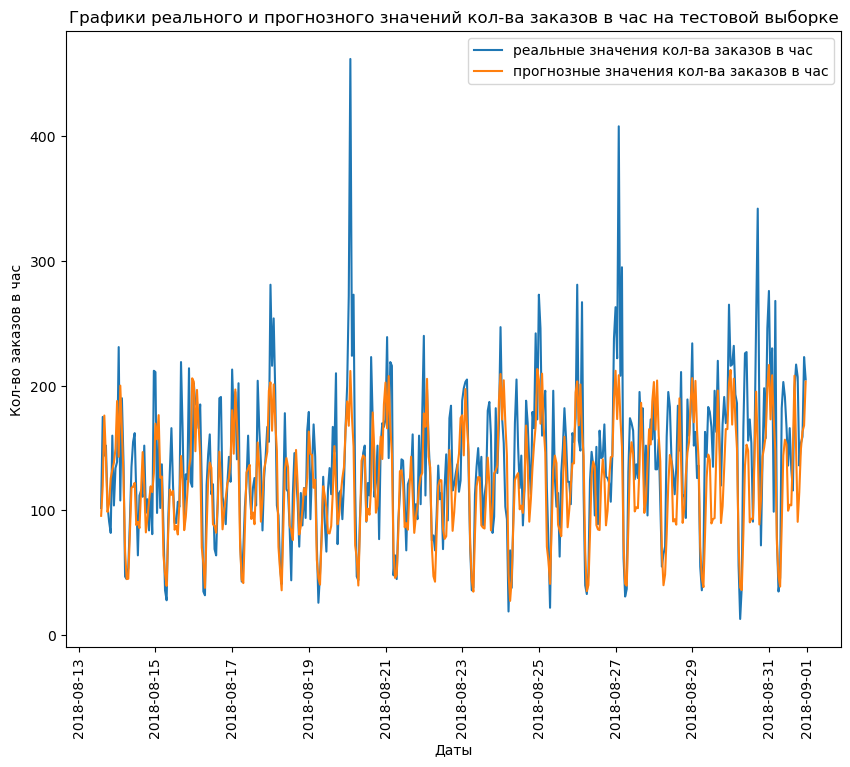

In [47]:
# построим графики для реальных и прогнозных значений на тестовой выборке
plt.figure(figsize=(10, 8))
sns.lineplot(x=X_test.index, y=y_test, label='реальные значения кол-ва заказов в час')
sns.lineplot(x=X_test.index, y=y_pred_test, label='прогнозные значения кол-ва заказов в час')
plt.xlabel('Даты')
plt.ylabel('Кол-во заказов в час')
plt.xticks(rotation=90)
plt.title('Графики реального и прогнозного значений кол-ва заказов в час на тестовой выборке')
plt.legend()
plt.show()

**Вывод:**

Лучшая выбранная модель RandomForestRegressor() показала хороший результат на тестовой выборке. Метрика RMSE на тестовой выборке равна 42.7. Мы сравнили результаты работы модели с результатами работы DummyRegressor(strategy="median"), которая в качестве прогноза для тестовой выборки выдает медианное значение, полученное на тренировочной выборке. В результате мы получили, что у модели DummyRegressor() метрика RMSE=87.15, что более чем в 2 раза превышает значение метрики для лучшей модели. Можно сделать вывод об адекватности полученной лучшей прогнозной модели. В заключении мы определили важность признаков для прогнозной модели и вывели графики для реальных и прогнозных значений на тестовой выборке. Наиболее значимым признаком для прогноза целевого признака оказался час (`hour`) (коэффициент 0.47), также высокая значимость у признаков `rolling_mean_15` (0.19) и `rolling_mean_10` (0.15), а у дня в месяце, дня недели, лагов в 2 и 3 часа значимость сравнительно низкая (коэффициенты 0.02-0.03). По диаграмме рассения мы видим, что модель лучше прогнозирует низкие значения и заметно хуже высокие, модель в целом чаще выдает заниженные значения кол-ва заказов в час.

**Общие выводы:**

На этапе подготовки данных мы выгрузили данные из файла и сохранили в датафрейм, при этом подключили автоматическое распознавание и преобразование строк даты и времени в объекты даты и времени и задали значения из первой колонки (со временем) в качестве индекса. Затем мы ресемплировали временой ряд по одному часу и отсортировали значения по индексу (по возрастанию).

На этапе анализа мы проанализировали целевой признак - почасовое кол-во заказов, а затем добавили необходимые входные признаки для прогнозирования целевого признака. Для наглядности мы построили графики по временному ряду. Наш временной ряд стационарный, что мы установили на тесте Дики-Фуллера. Почасовое кол-во заказов в целом за выбранный период имеет заметный тренд к росту, который наблюдается с середины апреля по конец августа. В конце мая - начале июня происходит незначительный спад. А в течение августа наблюдается наиболее резкий рост кол-ва заказов в час и наиболее резкие колебания кол-ва почасовых заказов. При этом сезонная составляющая указывает на цикличность в течение суток. По выборке максимальное значение кол-ва заказов в час составляет 462, а минимальное 0. Медианное значение кол-ва заказов за час - 78. График на более коротком промежутке за двое суток показывает, что обычно пиковые значения приходятся на 00 часов ночи, а минимуальные значения на 6 часов утра.

В качестве входных признаков для прогнозирования кол-ва почасовых заказов мы добавили день месяца (календарное число), день недели, час в течение суток, а также лаги на 1, 2, 3 часа и скользящее среднее с окнами в 10 и 15 часов.

Мы разбили временной ряд на тренировочную и тестовую выборки, сохранив хронологическую последовательность. В тестовую выборку попали заказы такси с 14 часов 13 августа по конец августа. В тестовую выборку попало 10% заказов - за 442 часа. При моделировании мы использовали пайплайн и инстурмент GridSearchCV для подбора оптимальных параметров лучшей модели на кросс-валидационной выборке. В подборе лучшей модели мы задействовали 6 регрессионных моделей: LenearRegressioin(), Lasso(), Ridge(), RandomForestRegressor(), KNeighborsRegressor() и CatBoostRegressor(). В результате работы GridResearchCV мы получили в качестве лучшей модели RandomForestRegressor() с оптимальными параметрами max_depth=18 и min_samples_leaf=5. У лучшей модели среднее значение RMSE на кросс-валидацитонной выборке составляет 25.7. Модели линейной регрессии с регуляризацией Lasso() и Ridge() не дают заметного улучшения по сравнению с LenearRegressioin(), однако все они дают очень хорошие результаты - средняя RMSE на кросс-валидацитонных выборках равна 26.2. DecisionTreeRegressor и KNeighborsRegressor дают заметно лучший результат.

Лучшая выбранная модель RandomForestRegressor() показала сравнительно хороший результат на тестовой выборке - значение метрики RMSE = 42.7. Мы сравнили результаты работы выбранной модели с результатами работы DummyRegressor(), которая в качестве прогноза для тестовой выборки выдает медианное значение, полученное на тренировочной выборке. У модели DummyRegressor() метрика RMSE = 87.15, что более чем в 2 раза превышает значение метрики для лучшей модели. Результат говорит об адекватности полученной лучшей прогнозной модели. Мы также определи важность признаков для прогнозной модели и вывели  диаграмму рассения для реальных и прогнозных значений на тестовой выборке. Наиболее значимым признаком для прогноза целевого признака оказался час (коэффициент 0.47), также достаточно значимым признаком является `rolling_mean_15` (0.19) и `rolling_mean_10` (0.15). День в месяце и день недели имеют сравнительно низкую значимость для целевого признака (коэффициенты меньше 0.1). По сопоставленным графикам прогнозов и реальных значений можно сказать, что модель гораздо лучше прогнозирует низкие значения и хуже высокие, например редко выдает пиковые значения заметно выше 200 и ниразу не выдает значения выше 300. В целом заметно, что модель чаще выдает заниженные значения кол-ва заказов в час.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48